# Plot ESN Training & Prediction Time

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import re

In [2]:
plt.style.use("../docs/xesn.mplstyle")

In [11]:
class ESNTiming():
    n_input = (16, 256,)
    n_reservoir = (500, 1000, 2000, 4000, 8000, 16000)
    mode = None
    proc = None
    iter = None
    
    red = {
        "walltime"   : re.compile(
            r"(Total Walltime: )(\d+\.\d+)( seconds)"),
    }
    
    def __init__(self, **kw):
        for k, v in kw.items():
            try:
                getattr(self, k)
            except:
                raise
            setattr(self, k, v)

        self.label = f"{self.proc}-{self.mode}"
            
    def __call__(self):
        
        dslist = []
        for n_s in self.n_input:
            dslist1 = []
            for n_r in self.n_reservoir:
                dslist1.append(self.read_stdout(n_r, n_s))
            dslist.append(self.ld2xds(dslist1, n_s))
        result = xr.concat(dslist, dim="n_input")
        result.attrs["label"] = self.label

        # now read memory
        
        return result
        
    def ld2xds(self, ld, n_s):
        xds = xr.Dataset()
        xds["n_reservoir"] = xr.DataArray(
            np.array(self.n_reservoir),
            coords={"n_reservoir": np.array(self.n_reservoir)},
            dims=("n_reservoir",)
        )
        
        dd = self.ld2dict(ld)
        for key, val in dd.items():
            xds[key] = xr.DataArray(
                val,
                coords=xds.n_reservoir.coords,
                dims=xds.n_reservoir.dims,
                attrs={
                    "units": "Seconds"
                }
            )
            
        xds = xds.expand_dims({"n_input": [n_s]})
        return xds
        
    def ld2dict(self, ld):
        """Map a list of dicts to single dict with arrays"""
        result = {}
        for key in ld[0].keys():
            result[key] = np.array([x[key][0] for x in ld])
        return result

    def get_stdout(self, n_r, n_i):
        if self.iter is None:
            return f"{self.proc}-{self.mode}/{n_r:05d}nr-{n_i:03d}/stdout.log"
        else:
            return f"{self.proc}-{self.mode}-{self.iter:02d}/{n_r:05d}nr-{n_i:03d}ni/stdout.log"
        
    def read_stdout(self, n_r, n_i):
        fname = self.get_stdout(n_r, n_i)
        result = {k: [] for k in self.red.keys()}
        with open(fname, "r") as f:
            for line in f:
                k, v = self._parse_line(line)
                if k is not None:
                    result[k].append(np.float64(v.group(2)))
                        
        return result
                        
    def _parse_line(self, line):
        for key,value in self.red.items():
            match = value.search(line)
            if match:
                return key, match
    
        # else no matches, return None
        return None, None

## Walltime

In [35]:
et = ESNTiming(mode="eager", proc="gcp-cpu", iter=1)
ds = et() 

[None, None]

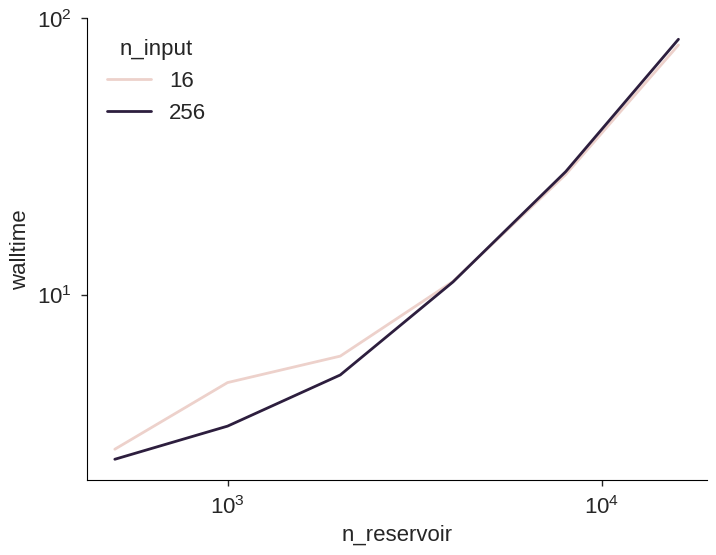

In [36]:
fig, ax = plt.subplots()
sns.lineplot(
    data=ds.to_dataframe().reset_index(),
    x="n_reservoir",
    y="walltime",
    hue="n_input",
)
ax.set(yscale="log", xscale="log")

## Memory

In [33]:
mds = xr.open_mfdataset("gcp-cpu-eager-02/*/memory.nc")

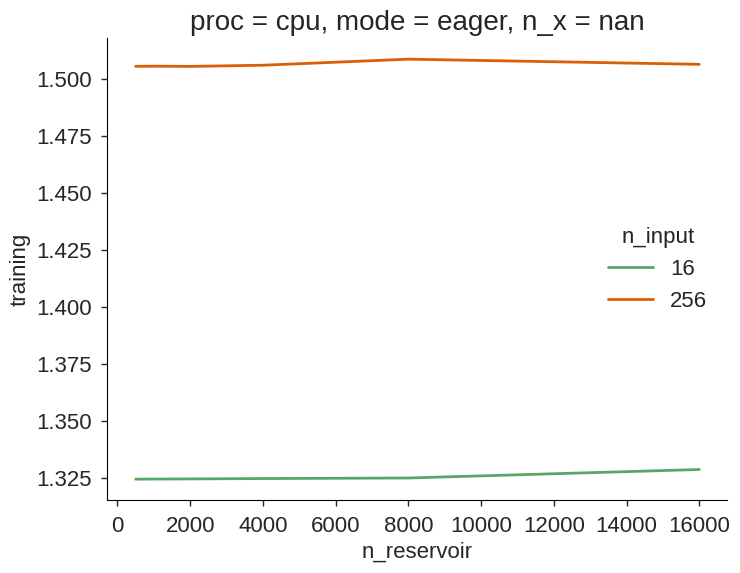

In [34]:
mgb = mds.training.squeeze().max("delta_t") / 1024 / 1024 / 1024
mgb.plot.line(x="n_reservoir")

In [31]:
mgb.mean("n_reservoir").values

array([1.3253301 , 1.50633812])

In [32]:
mgb.std("n_reservoir").values

array([0.00151888, 0.00111473])

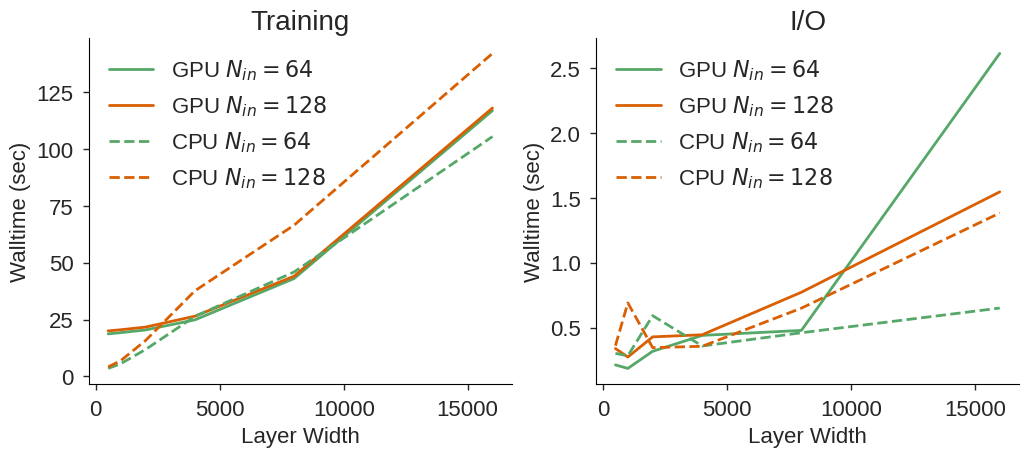

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12,4.5))
for key, label, ax in zip(["training", "io"], ["Training", "I/O"], axs):
    for xds, ls in zip(dslist, ["-", "--"]):
        for i, n_system in enumerate([64, 128]):#, ["--", "-"]):
            sns.lineplot(
                data=xds.sel(n_system=n_system).to_dataframe().reset_index(),
                x="n_reservoir",
                y=key,
                errorbar="sd",
                label=xds.label + r" $N_{in} = %d$" % n_system,
                linestyle=ls,
                ax=ax,
                color=f"C{i}",
            )
    ax.set(
        ylabel='Walltime (sec)',
        xlabel="Layer Width",
        title=label,
    )
    
#ds.training.plot.line(x='n_reservoir')

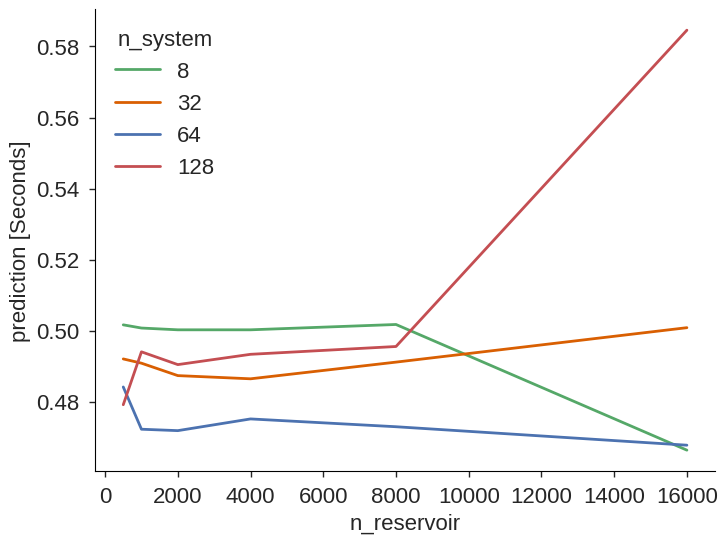

In [8]:
dslist[0].prediction.plot.line(x='n_reservoir')